In [1]:
import arff, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV



In [2]:
columns = ['Project', 'TeamExp', 'ManagerExp', 'YearEnd', 'Length', 'Effort', 'Transactions', 'Entities', 'PointsAjust', 'Envergure', 'PointsNonAdjust', 'Language']
df_desharnais = pd.read_csv('./desharnais.txt', names=columns, comment='%', skipinitialspace=True, delimiter=',')
df_desharnais.head()

print(df_desharnais['TeamExp'].unique())
print(df_desharnais['ManagerExp'].unique())

df_desharnais['TeamExp'] = df_desharnais['TeamExp'].replace('?', np.nan)
df_desharnais['TeamExp'] = pd.to_numeric(df_desharnais['TeamExp'], errors='coerce')
df_desharnais['TeamExp'].fillna(df_desharnais['TeamExp'].median(), inplace=True)

df_desharnais['ManagerExp'] = df_desharnais['ManagerExp'].replace('?', np.nan)
df_desharnais['ManagerExp'] = pd.to_numeric(df_desharnais['ManagerExp'], errors='coerce')
df_desharnais['ManagerExp'].fillna(df_desharnais['ManagerExp'].median(), inplace=True)



['1' '0' '4' '2' '3' '?']
['4' '0' '1' '2' '3' '?' '7' '5']


C:\Users\Vaishali Thakur\AppData\Local\Temp\ipykernel_31216\481515339.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_desharnais['TeamExp'].fillna(df_desharnais['TeamExp'].median(), inplace=True)
C:\Users\Vaishali Thakur\AppData\Local\Temp\ipykernel_31216\481515339.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

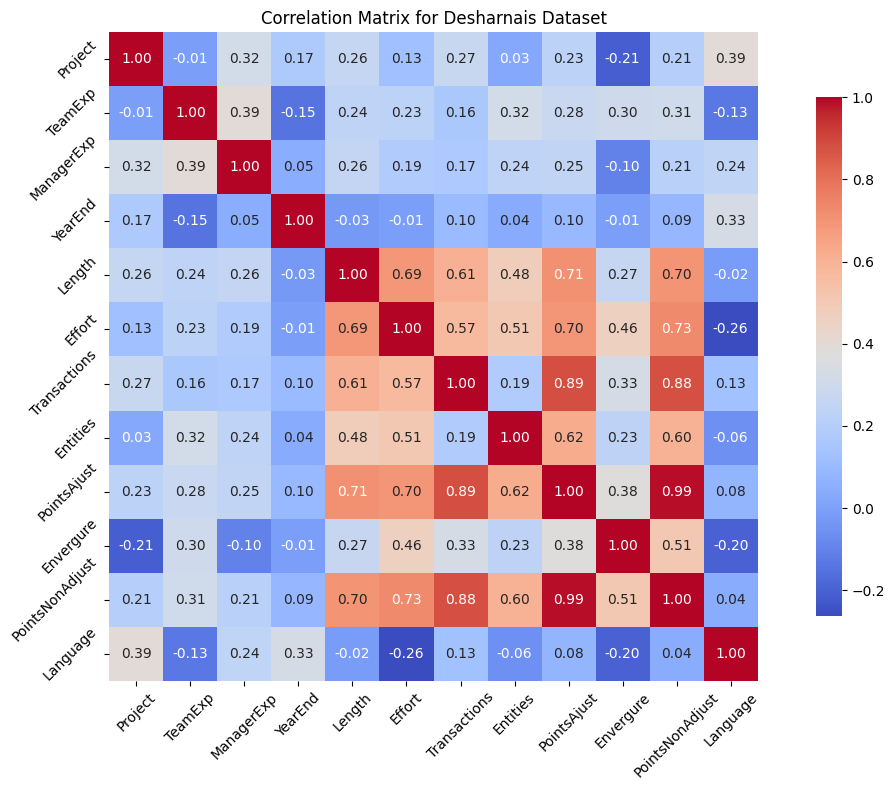

In [3]:
import seaborn as sns
correlation_matrix = df_desharnais.corr()

# Step 2: Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Step 3: Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Add title and labels
plt.title('Correlation Matrix for Desharnais Dataset')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjusts the plot to fit into the figure area.
plt.show()

In [4]:
max_corr_features = ['Length', 'Transactions', 'Entities','PointsNonAdjust','PointsAjust']


# Define the attributes to keep
attributes_to_keep = [
    'Project',         # numeric
    'TeamExp',         # numeric (measured in years)
    'ManagerExp',      # numeric (measured in years)
    'Length',          # numeric
    'Effort',          # ActualEffort is measured in person-hours
    'Envergure',       # numeric
    'Language'        # categorical {1,2,3}
]

# Create a new DataFrame with only the specified attributes
filtered_df_desharnais = df_desharnais[attributes_to_keep]

# Display the new DataFrame
print(filtered_df_desharnais.head())


   Project  TeamExp  ManagerExp  Length  Effort  Envergure  Language
0        1      1.0         4.0      12    5152         34         1
1        2      0.0         0.0       4    5635         33         1
2        3      4.0         4.0       1     805         18         1
3        4      0.0         0.0       5    3829         30         1
4        5      0.0         0.0       4    2149         24         1


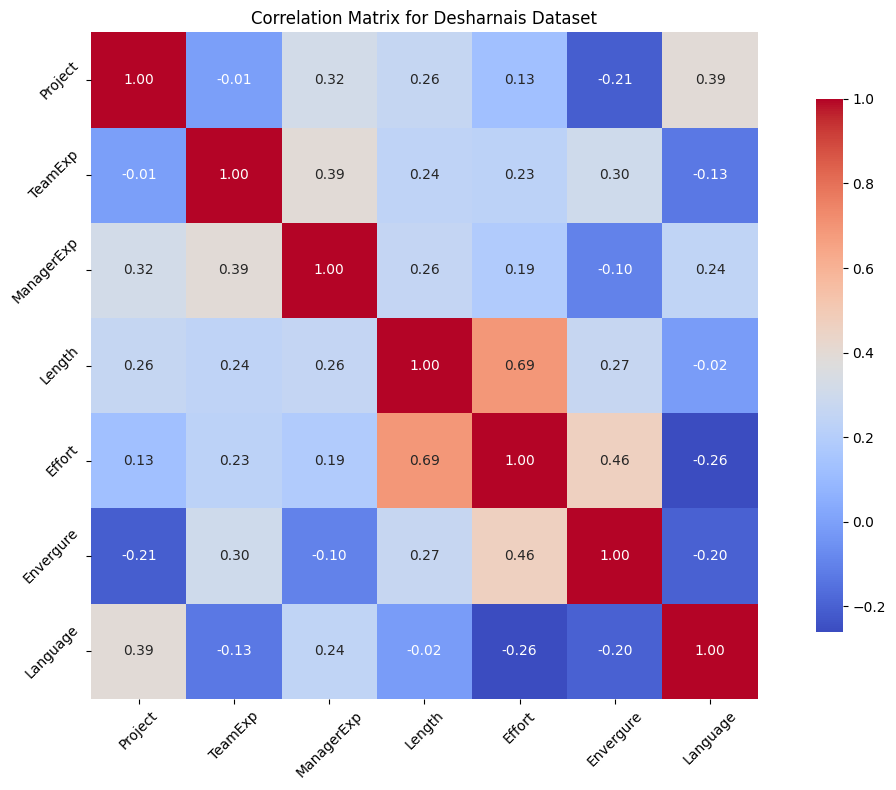

In [5]:
import seaborn as sns
correlation_matrix = filtered_df_desharnais.corr()

# Step 2: Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Step 3: Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Add title and labels
plt.title('Correlation Matrix for Desharnais Dataset')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjusts the plot to fit into the figure area.
plt.show()

In [6]:
features = df_desharnais.drop(columns=['Effort'])  # Input features
output = df_desharnais['Effort']                  

In [7]:
filtered_features = filtered_df_desharnais.drop(columns=['Effort'])  # Input features
filtered_output = filtered_df_desharnais['Effort']                  

In [10]:
print(features)

    Project  TeamExp  ManagerExp  YearEnd  Length  Transactions  Entities  \
0         1      1.0         4.0       85      12           253        52   
1         2      0.0         0.0       86       4           197       124   
2         3      4.0         4.0       85       1            40        60   
3         4      0.0         0.0       86       5           200       119   
4         5      0.0         0.0       86       4           140        94   
..      ...      ...         ...      ...     ...           ...       ...   
76       77      4.0         4.0       85      12           229       169   
77       78      4.0         3.0       83      12           227        73   
78       79      4.0         4.0       86      24           395       193   
79       80      4.0         3.0       86      12           469       176   
80       81      4.0         4.0       85      36           886       241   

    PointsAjust  Envergure  PointsNonAdjust  Language  
0           305    

In [11]:
print(output)

0      5152
1      5635
2       805
3      3829
4      2149
      ...  
76     1400
77     2800
78     9520
79     5880
80    23940
Name: Effort, Length: 81, dtype: int64


In [8]:
# Function to detect outliers using IQR for the entire dataframe
def detect_outliers_iqr(df):
    outliers_dict = {}
    for column in df.select_dtypes(include=[np.number]).columns:  # Only numeric columns
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        # Store outliers for each column
        if not outliers.empty:
            outliers_dict[column] = outliers
    return outliers_dict

# Detecting outliers for all numeric columns
outliers_dict = detect_outliers_iqr(features)

# Display outliers for each column
for column, outliers in outliers_dict.items():
    print(f"Outliers in '{column}':")
    print(outliers[['Project', column]])  # Display only the project and the outlier column
    print("\n")

Outliers in 'Length':
    Project  Length
41       42      34
43       44      39
45       46      27
80       81      36


Outliers in 'Transactions':
    Project  Transactions
40       41           451
41       42           661
72       73           482
75       76           473
79       80           469
80       81           886


Outliers in 'Entities':
    Project  Entities
18       19       386
55       56       387


Outliers in 'PointsAjust':
    Project  PointsAjust
41       42          793
72       73          709
80       81         1127


Outliers in 'PointsNonAdjust':
    Project  PointsNonAdjust
41       42              698
75       76              688
79       80              697
80       81             1116




In [9]:
def count_outliers(df):
    outlier_counts = {}
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_counts[column] = len(outliers)
    return outlier_counts

outlier_counts = count_outliers(features)

# Creating a table from the outlier counts
outlier_counts_df = pd.DataFrame(list(outlier_counts.items()), columns=['Feature', 'Outlier Count'])

# Displaying the table
print(outlier_counts_df)


            Feature  Outlier Count
0           Project              0
1           TeamExp              0
2        ManagerExp              0
3           YearEnd              0
4            Length              4
5      Transactions              6
6          Entities              2
7       PointsAjust              3
8         Envergure              0
9   PointsNonAdjust              4
10         Language              0


In [10]:
def count_outliers(df):
    outlier_counts = {}
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_counts[column] = len(outliers)
    return outlier_counts

outlier_counts = count_outliers(filtered_features)

# Creating a table from the outlier counts
outlier_counts_df = pd.DataFrame(list(outlier_counts.items()), columns=['Feature', 'Outlier Count'])

# Displaying the table
print(outlier_counts_df)


      Feature  Outlier Count
0     Project              0
1     TeamExp              0
2  ManagerExp              0
3      Length              4
4   Envergure              0
5    Language              0


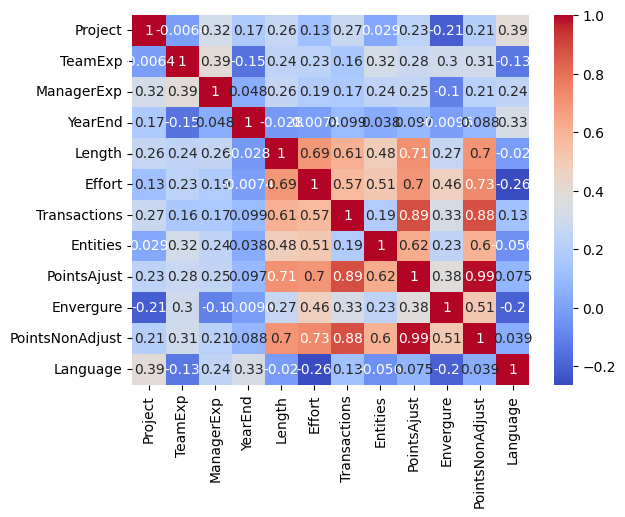

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
corr_matrix = df_desharnais.corr()

# Heatmap to visualize correlations
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [15]:
#Picked the entitites with more than 0.5 correraltion, however this shows teamexp and manager exp is less correlated
#according to my domain knowledge team exp and manager expereine also matters
features = [ 'TeamExp', 'ManagerExp', 'Length', 'Transactions', 'Entities',
        'PointsNonAdjust',  'PointsAjust']

max_corr_features = ['Length', 'Transactions', 'Entities','PointsNonAdjust','PointsAjust']

X = df_desharnais[features]
Y = df_desharnais['Effort']

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_absolute_error, mean_squared_error, 
                             r2_score, explained_variance_score)
import time

# Assuming filtered_desharnais is your DataFrame
# Replace 'Effort' with the actual name of your output column if different
X = filtered_features
y = filtered_output

# Number of splits to evaluate
num_splits = 5
results = []

# Loop for multiple train-test splits with varying train size
for i in range(num_splits):
    # Calculate the train size incrementally from 0.5 to 0.9
    train_size = 0.5 + (i * 0.1)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_size, random_state=i)
    
    # Initialize the Linear Regression model
    model = LinearRegression()

    # Start the timer for computation time
    start_time = time.time()

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Calculate PRED(25)
    pred_25 = np.mean(np.abs((y_test - y_pred) / y_test) <= 0.25) * 100

    # Calculate MAPE
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Calculate Explained Variance
    explained_variance = explained_variance_score(y_test, y_pred)

    # Calculate Maximum Error
    max_error = np.max(np.abs(y_test - y_pred))

    # Calculate Median Absolute Error
    median_ae = np.median(np.abs(y_test - y_pred))

    # Calculate computation time
    computation_time = time.time() - start_time

    # Store results for the current split
    results.append({
        'Train Size (%)': f"{int(train_size * 100)}%",  # Format train size as percentage
        'Test Size (%)': f"{int((1 - train_size) * 100)}%",  # Format test size as percentage
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R-Squared': r2,
        'PRED(25)': pred_25,
        'MAPE': mape,
        'Explained Variance': explained_variance,
        'Max Error': max_error,
        'Median AE': median_ae,
        'Computation Time (s)': computation_time
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel('effort_estimation_result.xlsx', index=False)

# Display the results
print(results_df)


  Train Size (%) Test Size (%)          MAE           MSE         RMSE  \
0            50%           50%  1897.657665  8.377474e+06  2894.386623   
1            60%           40%  2010.806540  6.091477e+06  2468.091749   
2            70%           30%  2628.236940  1.294660e+07  3598.138157   
3            80%           19%  2221.934880  8.458060e+06  2908.274406   
4            90%            9%  3938.312702  2.603930e+07  5102.871600   

   R-Squared   PRED(25)        MAPE  Explained Variance     Max Error  \
0   0.626508  46.341463   62.768933            0.640030  10871.061568   
1   0.540162  30.303030   85.967649            0.545899   5308.214247   
2  -0.299766  36.000000   78.300597           -0.158242  11432.152609   
3   0.619706  23.529412   46.799480            0.668435   5659.136442   
4  -0.320127  33.333333  149.232561           -0.197982  10737.553810   

     Median AE  Computation Time (s)  
0  1235.109201              0.007351  
1  1949.716300              0.008002  

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import (mean_absolute_error, mean_squared_error, 
                             r2_score, explained_variance_score)
import time

# Assuming filtered_desharnais is your DataFrame
# Replace 'Effort' with the actual name of your output column if different
X = filtered_features
y = filtered_output

# Number of splits to evaluate
num_splits = 5
results = []

# Loop for multiple train-test splits with varying train size
for i in range(num_splits):
    # Calculate the train size incrementally from 0.5 to 0.9
    train_size = 0.5 + (i * 0.1)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_size, random_state=i)
    
    # Initialize the Support Vector Regression model
    model = SVR(kernel='linear')  # You can change the kernel to 'rbf' or others if needed

    # Start the timer for computation time
    start_time = time.time()

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Calculate PRED(25)
    pred_25 = np.mean(np.abs((y_test - y_pred) / y_test) <= 0.25) * 100

    # Calculate MAPE
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Calculate Explained Variance
    explained_variance = explained_variance_score(y_test, y_pred)

    # Calculate Maximum Error
    max_error = np.max(np.abs(y_test - y_pred))

    # Calculate Median Absolute Error
    median_ae = np.median(np.abs(y_test - y_pred))

    # Calculate computation time
    computation_time = time.time() - start_time

    # Store results for the current split
    results.append({
        'Train Size (%)': f"{int(train_size * 100)}%",  # Format train size as percentage
        'Test Size (%)': f"{int((1 - train_size) * 100)}%",  # Format test size as percentage
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R-Squared': r2,
        'PRED(25)': pred_25,
        'MAPE': mape,
        'Explained Variance': explained_variance,
        'Max Error': max_error,
        'Median AE': median_ae,
        'Computation Time (s)': computation_time
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel('effort_estimation_results_desharnais_svr.xlsx', index=False)

# Display the results
print(results_df)


  Train Size (%) Test Size (%)          MAE           MSE         RMSE  \
0            50%           50%  2315.977463  1.440310e+07  3795.141054   
1            60%           40%  2213.268939  9.011582e+06  3001.929662   
2            70%           30%  2118.790698  8.074374e+06  2841.544320   
3            80%           19%  3003.283327  1.771606e+07  4209.044626   
4            90%            9%  2893.645952  1.539494e+07  3923.638451   

   R-Squared   PRED(25)        MAPE  Explained Variance     Max Error  \
0   0.357869  36.585366   72.382540            0.384895  16144.052000   
1   0.319727  30.303030  108.709064            0.320098   9600.502551   
2   0.189378  32.000000   50.927534            0.259724   8783.718195   
3   0.203444  23.529412   78.185505            0.292864   9966.828324   
4   0.219515  11.111111  109.392956            0.220613  10126.025910   

     Median AE  Computation Time (s)  
0  1359.900000              0.005998  
1  1621.490306              0.006001  

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import (mean_absolute_error, mean_squared_error, 
                             r2_score, explained_variance_score)
import time

# Assuming filtered_desharnais is your DataFrame
X=filtered_features
Y=filtered_output

# Define a parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],            # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],         # Shrinkage factor
    'max_depth': [3, 5, 7],                     # Maximum depth of each tree
    'min_samples_split': [10, 20],              # Minimum samples to split an internal node
    'min_samples_leaf': [1, 5, 10],             # Minimum samples required at a leaf node
    'subsample': [0.8, 1.0],                    # Fraction of samples to use for training
    'max_features': ['sqrt', 'log2']             # Number of features to consider for the best split
}

# Initialize the Gradient Boosting Regressor model
gbr = GradientBoostingRegressor()

# Initialize GridSearchCV to search for the best parameters
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, 
                           scoring='r2',  # You can change this to 'neg_mean_squared_error', etc.
                           cv=5,          # 5-fold cross-validation
                           verbose=1,     # Print progress
                           n_jobs=-1)     # Use all cores available

# Train-test splits to evaluate
splits = [0.5, 0.6, 0.7, 0.8, 0.9]
results_list = []

# Loop over each train-test split
for train_size in splits:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_size, random_state=42)
    
    # Perform the grid search for each train-test split
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters
    best_params = grid_search.best_params_
    print(f"Best hyperparameters for train size {train_size * 100}%:", best_params)
    
    # Train the Gradient Boosting Regressor with the best hyperparameters
    best_model = grid_search.best_estimator_
    
    # Start the timer for computation time
    start_time = time.time()

    # Fit the model on the training set
    best_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    pred_25 = np.mean(np.abs((y_test - y_pred) / y_test) <= 0.25) * 100
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    explained_variance = explained_variance_score(y_test, y_pred)
    max_error = np.max(np.abs(y_test - y_pred))
    median_ae = np.median(np.abs(y_test - y_pred))
    computation_time = time.time() - start_time

    # Store results for the current train-test split
    results = {
        'Train Size (%)': f"{int(train_size * 100)}%",
        'Test Size (%)': f"{int((1 - train_size) * 100)}%",
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R-Squared': r2,
        'PRED(25)': pred_25,
        'MAPE': mape,
        'Explained Variance': explained_variance,
        'Max Error': max_error,
        'Median AE': median_ae,
        'Computation Time (s)': computation_time
    }

    # Append the results for each split to the results list
    results_list.append(results)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results_list)

# Save the results to an Excel file
results_df.to_excel('effort_estimation_desharnais_gbr.xlsx', index=False)

# Display the results
print(results_df)


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best hyperparameters for train size 50.0%: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 1.0}
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best hyperparameters for train size 60.0%: {'learning_rate': 0.05, 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100, 'subsample': 0.8}
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best hyperparameters for train size 70.0%: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 300, 'subsample': 0.8}
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best hyperparameters for train size 80.0%: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estim

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_absolute_error, mean_squared_error, 
                             r2_score, explained_variance_score)
import time

# Assuming X_china_filtered and Y_china_filtered are your filtered datasets
X = filtered_features
y = filtered_output

# Default parameters for RandomForestRegressor
# Default parameters used:
# n_estimators: 100
# max_depth: None (nodes are expanded until all leaves contain less than min_samples_split samples)
# min_samples_split: 2
# min_samples_leaf: 1
# bootstrap: True

# Initialize Random Forest Regressor model with default parameters
rf = RandomForestRegressor()

# Initialize an empty list to store results
results = []

# Loop for different train-test splits
for i, train_size in enumerate([0.5, 0.6, 0.7, 0.8, 0.9]):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_size, random_state=42)

    # Start the timer for computation time
    start_time = time.time()

    # Fit the model with default hyperparameters
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    pred_25 = np.mean(np.abs((y_test - y_pred) / y_test) <= 0.25) * 100
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    explained_variance = explained_variance_score(y_test, y_pred)
    max_error = np.max(np.abs(y_test - y_pred))
    median_ae = np.median(np.abs(y_test - y_pred))
    computation_time = time.time() - start_time

    # Store the results
    results.append({
        'Train Size (%)': f"{int(train_size * 100)}%",
        'Test Size (%)': f"{int((1 - train_size) * 100)}%",
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R-Squared': r2,
        'PRED(25)': pred_25,
        'MAPE': mape,
        'Explained Variance': explained_variance,
        'Max Error': max_error,
        'Median AE': median_ae,
        'Computation Time (s)': computation_time
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel('effort_estimation_results_rf_desharnais.xlsx', index=False)

# Display the results
print(results_df)


  Train Size (%) Test Size (%)          MAE           MSE         RMSE  \
0            50%           50%  2408.392683  1.217639e+07  3489.468052   
1            60%           40%  2567.549091  1.462202e+07  3823.875175   
2            70%           30%  2276.948800  1.018930e+07  3192.068562   
3            80%           19%  2018.714118  8.314596e+06  2883.504037   
4            90%            9%  1278.518889  2.588963e+06  1609.025427   

   R-Squared   PRED(25)       MAPE  Explained Variance  Max Error  Median AE  \
0   0.379403  29.268293  87.894662            0.384451   13620.95    1736.70   
1   0.335123  27.272727  85.101697            0.340282   14076.93    1488.20   
2   0.227240  36.000000  88.929329            0.243396    9313.46    1702.12   
3   0.348322  29.411765  85.978691            0.352113    9143.60    1358.10   
4   0.432722  33.333333  62.731847            0.551356    2903.53    1180.06   

   Computation Time (s)  
0              0.283662  
1              0.26029

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_absolute_error, mean_squared_error, 
                             r2_score, explained_variance_score)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
import time

# Assuming filtered_features and filtered_output are your datasets
X = filtered_features
y = filtered_output

# Define base learners
base_learners = [
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('Neural Net', MLPRegressor(max_iter=1000)),
    ('Elastic Net', ElasticNet()),
    ('XGBoost', xgb.XGBRegressor()),
    ('SVM', SVR())
]

# Initialize an empty list to store results
results = []

# Loop for different train-test splits
for train_size in [0.5, 0.6, 0.7, 0.8, 0.9]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_size, random_state=42)
    
    # Create a new dataset for the meta-learner
    base_predictions_train = []
    base_predictions_test = []

    # Start the computation time measurement
    start_time = time.time()

    # Loop through each base learner
    for name, model in base_learners:
        # Fit the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Store predictions for the meta-learner
        base_predictions_train.append(y_pred_train)
        base_predictions_test.append(y_pred_test)

    # Convert predictions to DataFrame for the meta-learner
    base_predictions_train = np.column_stack(base_predictions_train)
    base_predictions_test = np.column_stack(base_predictions_test)

    # Initialize a meta-learner (e.g., linear regression)
    meta_learner = LinearRegression()

    # Train the meta-learner
    meta_learner.fit(base_predictions_train, y_train)

    # Make final predictions
    final_predictions = meta_learner.predict(base_predictions_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, final_predictions)
    mse = mean_squared_error(y_test, final_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, final_predictions)
    pred_25 = np.mean(np.abs((y_test - final_predictions) / y_test) <= 0.25) * 100
    mape = np.mean(np.abs((y_test - final_predictions) / y_test)) * 100
    explained_variance = explained_variance_score(y_test, final_predictions)
    max_error = np.max(np.abs(y_test - final_predictions))
    median_ae = np.median(np.abs(y_test - final_predictions))

    # End the computation time measurement
    computation_time = time.time() - start_time

    # Store the results
    results.append({
        'Train Size (%)': f"{int(train_size * 100)}%",
        'Test Size (%)': f"{int((1 - train_size) * 100)}%",
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R-Squared': r2,
        'PRED(25)': pred_25,
        'MAPE': mape,
        'Explained Variance': explained_variance,
        'Max Error': max_error,
        'Median AE': median_ae,
        'Computation Time (s)': computation_time
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel('effort_estimation_results_final_with_stacking_desharnais.xlsx', index=False)

# Display the results
print(results_df)


c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train Size (%) Test Size (%)          MAE           MSE         RMSE  \
0            50%           50%  3147.268293  2.479306e+07  4979.263242   
1            60%           40%  3427.878788  2.121082e+07  4605.520620   
2            70%           30%  3147.640000  1.759677e+07  4194.850619   
3            80%           19%  2610.823529  1.358620e+07  3685.946458   
4            90%            9%  1968.888889  7.299328e+06  2701.726855   

   R-Squared   PRED(25)        MAPE  Explained Variance     Max Error  \
0  -0.263634  17.073171   92.452590           -0.252086  21587.999999   
1   0.035525  15.151515   99.009827            0.044376  14840.000000   
2  -0.334544  16.000000  108.770100           -0.321087   9807.000000   
3  -0.064853  29.411765   89.313987           -0.017814  11046.000000   
4  -0.599386  33.333333   50.329526           -0.586928   6510.000000   

   Median AE  Computation Time (s)  
0     1925.0              0.580823  
1     2702.0              0.729834  
2    

c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from pyearth import Earth  # MARS model
from sklearn.metrics import (mean_absolute_error, mean_squared_error, 
                             r2_score, explained_variance_score)

# Assuming filtered_features and filtered_output are your datasets
X = filtered_features
y = filtered_output

# Initialize an empty list to store results
results = []

# Loop for different train-test splits
for train_size in [0.5, 0.6, 0.7, 0.8, 0.9]:
    # Start computation time
    start_time = time.time()
    
    # Step 1: Preprocess the data
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_size, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Step 2: Perform Principal Component Analysis (PCA)
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Choose the number of components based on explained variance
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(explained_variance >= 0.95) + 1  # For 95% explained variance
    X_train_pca = X_train_pca[:, :n_components]
    X_test_pca = X_test_pca[:, :n_components]

    # Step 3: Fit the PCR model
    pcr_model = LinearRegression()
    pcr_model.fit(X_train_pca, y_train)

    # Step 4: Predict using the PCR model
    y_pred_pcr = pcr_model.predict(X_test_pca)

    # Step 5: Fit the MARS model on the original features
    mars_model = Earth()
    mars_model.fit(X_train, y_train)

    # Step 6: Predict using the MARS model
    y_pred_mars = mars_model.predict(X_test)

    # Step 7: Combine predictions from PCR and MARS
    # Weight parameter for combining predictions
    w = 0.5  # Weight for PCR predictions
    final_y_pred = w * y_pred_pcr + (1 - w) * y_pred_mars

    # Step 8: Evaluate the hybrid model
    mae = mean_absolute_error(y_test, final_y_pred)
    mse = mean_squared_error(y_test, final_y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, final_y_pred)
    pred_25 = np.mean(np.abs((y_test - final_y_pred) / y_test) <= 0.25) * 100
    mape = np.mean(np.abs((y_test - final_y_pred) / y_test)) * 100
    explained_variance = explained_variance_score(y_test, final_y_pred)
    max_error = np.max(np.abs(y_test - final_y_pred))
    median_ae = np.median(np.abs(y_test - final_y_pred))

    # End computation time
    computation_time = time.time() - start_time

    # Step 9: Store the results
    results.append({
        'Train Size (%)': f"{int(train_size * 100)}%",
        'Test Size (%)': f"{int((1 - train_size) * 100)}%",
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R-Squared': r2,
        'PRED(25)': pred_25,
        'MAPE': mape,
        'Explained Variance': explained_variance,
        'Max Error': max_error,
        'Median AE': median_ae,
        'Computation Time (s)': computation_time
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel('hybrid_pcr_mars_results_with_metrics.xlsx', index=False)

# Display the results
print(results_df)


# desharnais n_estimator=500 and max_features= 1 to 8

In [14]:

X_train, X_test, y_train, y_test = train_test_split(
    filtered_features, filtered_output, test_size=0.30, random_state=42)

In [15]:
MMRE_list=[]
MdMRE_list=[]
Pred_list= []
for i in np.arange(1,9):   
    clf= RandomForestRegressor(n_estimators=500,max_features=i)
    clf.fit(X_train, y_train)
    Y_pred=clf.predict(X_test)
    diff=np.absolute(y_test-Y_pred)
    MRE=diff/y_test
    MMRE=np.mean(MRE)
    MdMRE=np.median(MRE)
    P=MRE[MRE<.25]
    Pred=(P.size/MRE.size) * 100
    MMRE_list.append(MMRE)
    MdMRE_list.append(MdMRE)
    Pred_list.append(Pred)

In [16]:
MMRE_list

[np.float64(0.9322142805047782),
 np.float64(0.9641561512548512),
 np.float64(0.9371875881865652),
 np.float64(0.9105172936504634),
 np.float64(0.920801198596098),
 np.float64(0.9452835034859416),
 np.float64(0.9381134345041889),
 np.float64(0.9277346823035603)]

In [17]:
MdMRE_list

[np.float64(0.40922130470685386),
 np.float64(0.3717687861271676),
 np.float64(0.3762702423929861),
 np.float64(0.37208114148186355),
 np.float64(0.3879656180161595),
 np.float64(0.3864003122560499),
 np.float64(0.3703135636926251),
 np.float64(0.40556953756231734)]

In [18]:
Pred_list

[24.0,
 28.000000000000004,
 28.000000000000004,
 32.0,
 32.0,
 32.0,
 28.000000000000004,
 28.000000000000004]

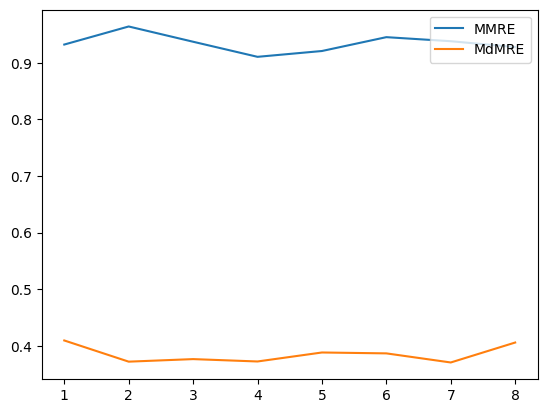

In [19]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(1,9)

plt.plot(x, MMRE_list)
plt.plot(x, MdMRE_list)

plt.legend(['MMRE','MdMRE'], loc='upper right')

plt.show()

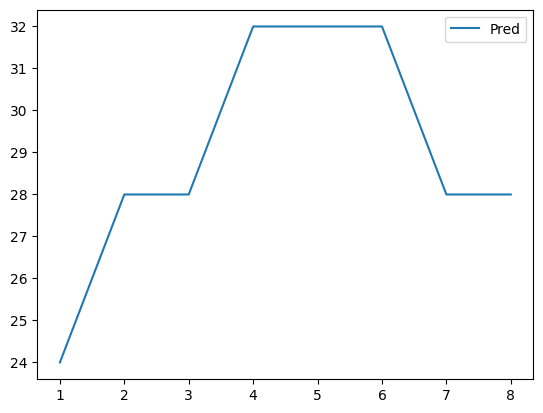

In [20]:
plt.plot(x, Pred_list)
plt.legend(['Pred'], loc='upper right')
plt.show()

# desharnais n_estimator=100 to 1000 and max_features= 5


In [21]:
MMRE_list=[]
MdMRE_list=[]
Pred_list= []
for i in np.arange(100,1100,100):   
    clf= RandomForestRegressor(n_estimators=i,max_features=5)
    clf.fit(X_train, y_train)
    Y_pred=clf.predict(X_test)
    diff=np.absolute(y_test-Y_pred)
    MRE=diff/y_test
    MMRE=np.mean(MRE)
    MdMRE=np.median(MRE)
    P=MRE[MRE<.25]
    Pred=(P.size/MRE.size) * 100
    MMRE_list.append(MMRE)
    MdMRE_list.append(MdMRE)
    Pred_list.append(Pred)

In [22]:
MMRE_list

[np.float64(0.9887314928893859),
 np.float64(0.975023166843047),
 np.float64(0.9259643327189114),
 np.float64(0.9421964035105568),
 np.float64(0.9321591889025638),
 np.float64(0.9472541448980616),
 np.float64(0.9503692599089199),
 np.float64(0.9326634476707263),
 np.float64(0.9170277788588845),
 np.float64(0.9499932360698908)]

In [23]:
MdMRE_list

[np.float64(0.39569364161849707),
 np.float64(0.41016003122560496),
 np.float64(0.38007704286533894),
 np.float64(0.3880316314251332),
 np.float64(0.3652487536530858),
 np.float64(0.3807091284167097),
 np.float64(0.38318524521722047),
 np.float64(0.3713406824823792),
 np.float64(0.3758999484270243),
 np.float64(0.3760266460374764)]

In [24]:
Pred_list

[28.000000000000004,
 24.0,
 28.000000000000004,
 28.000000000000004,
 32.0,
 32.0,
 32.0,
 28.000000000000004,
 32.0,
 36.0]

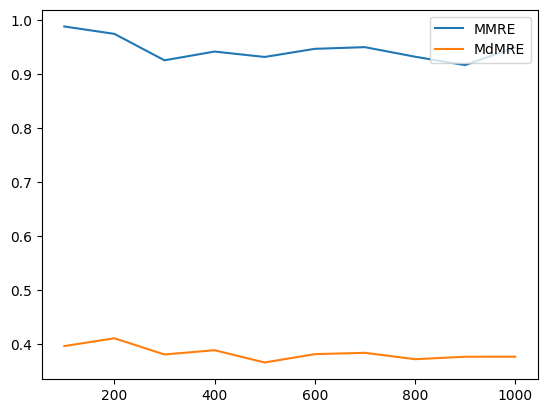

In [25]:
x = np.arange(100,1100,100)
plt.plot(x, MMRE_list)
plt.plot(x, MdMRE_list)

plt.legend(['MMRE','MdMRE'], loc='upper right')

plt.show()

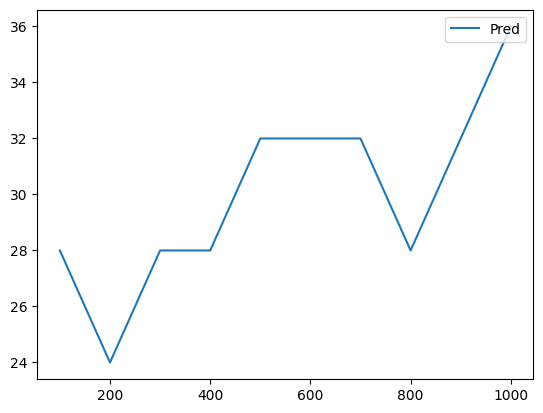

In [26]:
plt.plot(x, Pred_list)
plt.legend(['Pred'], loc='upper right')
plt.show()

# GridSearchCV

In [27]:
params_grd={
 'max_features': [1,2,3,4,5,6,7,8],
  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [28]:
clf= RandomForestRegressor()
grd_search=GridSearchCV(estimator = clf, param_grid = params_grd, 
                          cv = 10, n_jobs = -1, verbose = 2)
grd_search.fit(X_train, y_train)
best_grid = grd_search.best_estimator_

Y_pred=best_grid.predict(X_test)
diff=np.absolute(y_test-Y_pred)
MRE=diff/y_test
MMRE=np.mean(MRE)
MdMRE=np.median(MRE)
P=MRE[MRE<.25]
Pred=(P.size/MRE.size) * 100


Fitting 10 folds for each of 80 candidates, totalling 800 fits


In [29]:
print(MMRE)
print(MdMRE)
print(Pred)

0.9477921595771651
0.4939943376194408
24.0


In [30]:
grd_search.best_params_

{'max_features': 1, 'n_estimators': 1400}


# Random Hyperparameter Grid

In [31]:
Random_grid={'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': [1,2,3,4,5,6,7,8],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [32]:
clf= RandomForestRegressor()
random_grd_search=RandomizedSearchCV(estimator = clf, param_distributions = Random_grid, n_iter = 100, cv = 10, 
                              verbose=2, random_state=42, n_jobs = -1)
random_grd_search.fit(X_train, y_train)
best_grid = random_grd_search.best_estimator_

Y_pred=best_grid.predict(X_test)
diff=np.absolute(y_test-Y_pred)
MRE=diff/y_test
MMRE=np.mean(MRE)
MdMRE=np.median(MRE)
P=MRE[MRE<.25]
Pred=(P.size/MRE.size) * 100


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


KeyboardInterrupt: 

In [ ]:
print(MMRE)
print(MdMRE)
print(Pred)

In [ ]:
random_grd_search.best_params_

#  Regression Tree Analysis

In [37]:
clf= DecisionTreeRegressor(max_depth=30, min_samples_split=20)
clf.fit(X_train, y_train)
Y_pred=clf.predict(X_test)
diff=np.absolute(y_test-Y_pred)
MRE=diff/y_test
MMRE=np.mean(MRE)
MdMRE=np.median(MRE)
P=MRE[MRE<.25]
Pred=(P.size/MRE.size) * 100

In [ ]:
print(MMRE)
print(MdMRE)
print(Pred)